# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** xx

**Author 1 (sciper):** Student Name 1 (xxxxx)  
**Author 2 (sciper):** Student Name 2 (xxxxx)   
**Author 3 (sciper):** Student Name 3 (xxxxx)   

**Release date:** 05.03.2025   
**Due date:** 19.03.2025 (11:59 pm)


## Key Submission Guidelines:
- **Before submitting your notebook, <span style="color:red;">rerun</span> it from scratch!** Go to: `Kernel` > `Restart & Run All`  
- **Only groups of three will be accepted**, except in exceptional circumstances.  
- **You are not allowed to use any libraries** other than those provided in this notebook.  
- **Failure to follow these guidelines may result in point deductions** during grading.  


[iapr]: https://github.com/LTS5/iapr2025

In [2]:
# Check is at least python 3.9
import sys 
assert (sys.version_info.major == 3) and (sys.version_info.minor == 13) # Change to current version of python environment

In [2]:
# Install required packages
!pip install numpy -q
!pip install matplotlib -q
!pip install scikit-image -q
!pip install pillow -q

In [3]:
# Import main packages
from utils.lab_01_utils import *
from skimage.color import rgb2hsv
from skimage.morphology import closing, opening, disk, remove_small_holes, remove_small_objects, binary_dilation

---
# Introduction


In this lab, we will be working with histological data. Histological images are created from tissue samples that are digitized using high-resolution scanners. Without preparation, human tissues lack visual contrast and have poor tissue differentiations. To overcome this issue, clinical institutes use chemical staining to artificially enhance contrast. The most famous one is called HE (hematoxylin and eosin) staining. Hematoxylin stains tissue nuclei with a deep purple while eosin focuses more on extracellular matrix components with a pink stain.

Before running the following code make sure that the images are located as follows:

```code
├── labs
|   ├── utils
|   |   └── lab_01_utils.py
|   └── lab_01_iapr.ipynb
└── data
    └── data_lab_01
        ├── tcga_crc_example.png
        └── tcga_blood_example.png
```
**⚠️ DO NOT CHANGE THIS CONFIGURATION, AS WE WILL RERUN YOUR NOTEBOOK USING THIS EXACT STRUCTURE!**

By running the following cells you will display a HE histological sample of a colorectal cancer case. It is composed of 3 main entities:
* **Mucin**: Grayish mucus that is secreted by the body. The presence of a tumor tends to increase its presence. 
* **Tumor**: Dark purple aggregates (hematoxylin). Mainly composed of cancerous cells.
* **Other**: Mixture of other cells such as stromal or lymphocytes. It appears mainly pink (eosin) but is dotted with nuclei (purple).

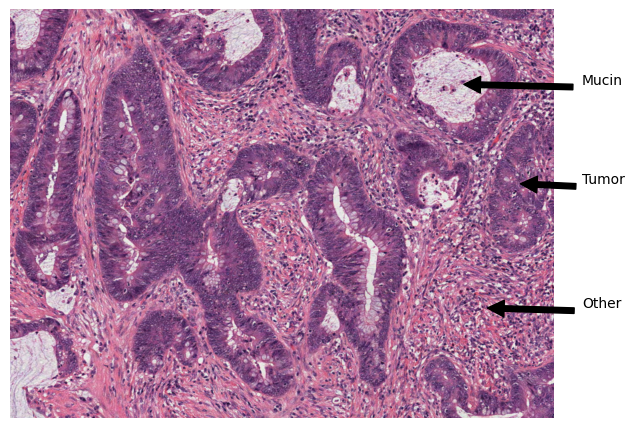

In [4]:
img_he = show_introduction_figure()


# Part 1 - Segmentation [16 pts]

## Part 1.1 - RGB (3 pts)

**Q1 (1 pts)**: In this section, you will have to complete the function `extract_rgb_channels`. The function should extract and return red, blue, and green channels from the input image `img`. Your function will be fed to `plot_colors_histo` to plot the distribution of the colors in the image. 

In [9]:
def extract_rgb_channels(img):
    """
    Extract RGB channels from the input image.

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    
    Return
    ------
    data_red: np.ndarray (M, N)
        Red channel of input image
    data_green: np.ndarray (M, N)
        Green channel of input image
    data_blue: np.ndarray (M, N)
        Blue channel of input image
    """

    # Get the shape of the input image
    M, N, _ = np.shape(img)

    # Define default values for RGB channels
    data_red = np.zeros((M, N))
    data_green = np.zeros((M, N))
    data_blue = np.zeros((M, N))

    # ------------------
    # Your code here ... 
    # ------------------

    # Extract the RGB channels
    data_red = img[:, :, 0]
    data_green = img[:, :, 1]
    data_blue = img[:, :, 2]

    # ------------------
    # End your code ...
    # ------------------

    
    return data_red, data_green, data_blue

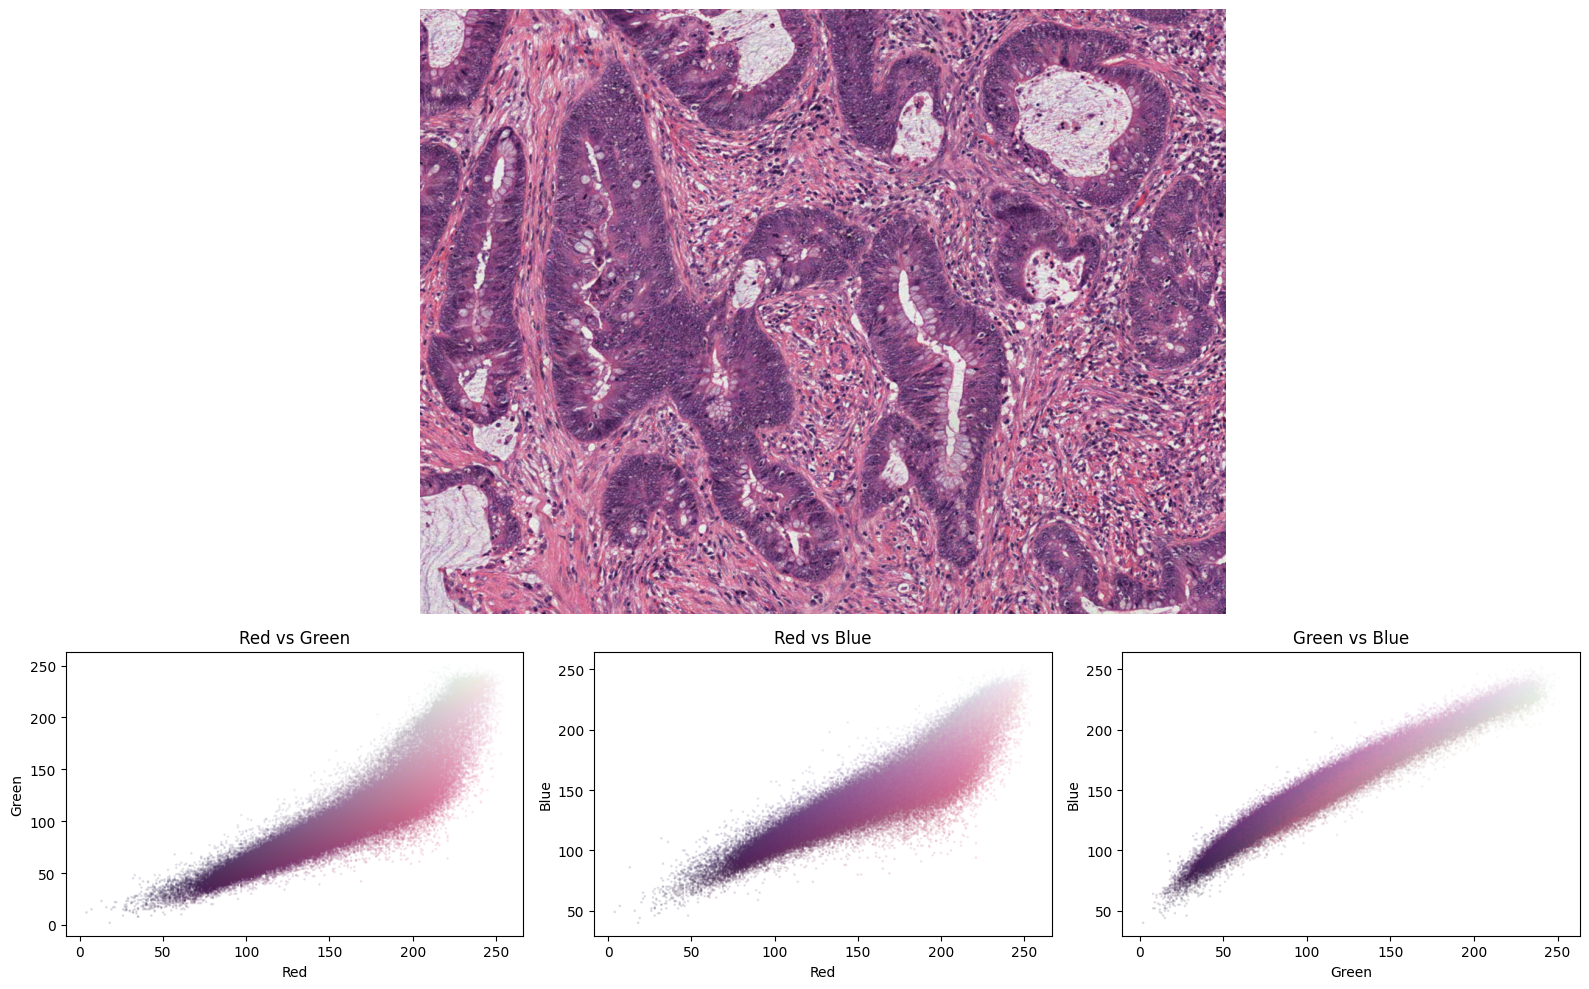

In [ ]:
################################################################
############################ TEST ##############################
################################################################

plot_colors_histo(
    img = img_he,
    func = extract_rgb_channels,
    labels = ["Red", "Green", "Blue"],
)

Based on the result of the plot above

* **Q2 (1 pts)**: Do you think you can find a simple manual thresholding approach to isolate the tumor components? (Justify)
    * **Answer**: Yes, since the tumor is defined as the "dark purple aggregates" a simple RGB threshold to filter out anything that is not dark purple should work quite well to isolate them. From the above plots, it seems a good threshold would be pixels with approximately the following RGB characteristics and darker (R > 125, G < 75, B < 115). Though some filtering of the tiny features may have to be done aftrwords.
* **Q3 (1 pts)**: Implement your own manual thresholding in `apply_rgb_threshold` to estimate the tumor location. Use the function `plot_thresholded_image` below to display your estimation results. Do you think your estimation is reliable? (justify)
    * **Answer**: The estimation made below dos a good job of isolating the parts the same color as the tumor. However, there are parts of the healthy tissue that are also that same color, though their features are tiny in comparison. Therefore, to get more accurate boundaries to our tumors and to properly identify only the tumor and not any other small part of the healthy tissue, some filtering of small features should be done.

In [43]:
def apply_rgb_threshold(img):
    """
    Apply threshold to input image.

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    
    Return
    ------
    img_th: np.ndarray (M, N)
        Thresholded image.
    """

    # Define the default value for the input image
    M, N, C = np.shape(img)
    img_th = np.zeros((M, N))

    # Use the previous function to extract RGB channels
    data_red, data_green, data_blue = extract_rgb_channels(img=img)
    
    # ------------------
    # Your code here ... 
    # ------------------

    RGB = extract_rgb_channels(img)
    R_th = 40 # Greater than
    G_th = 95  # Less than
    B_th = 165 # Less than
    img_th = (RGB[0] > R_th) & (RGB[1] < G_th) & (RGB[2] < B_th)

    # ------------------
    # End your code ...
    # ------------------
    
    return  img_th

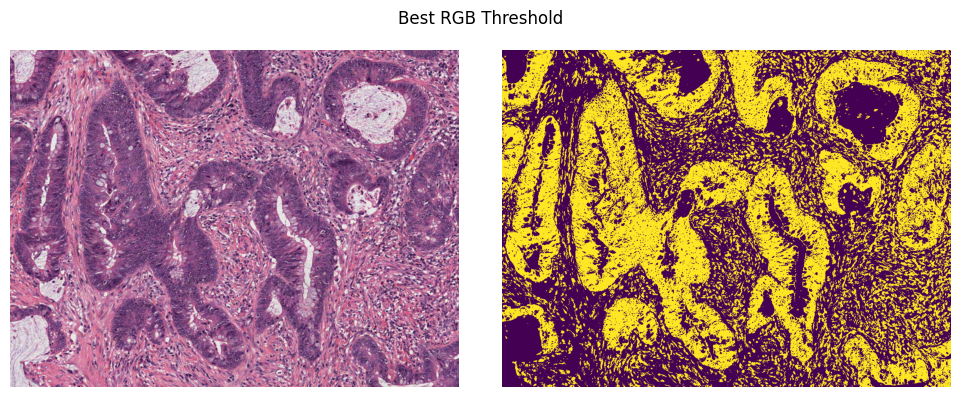

In [44]:
################################################################
############################ TEST ##############################
################################################################

# Plot best RGB thresholding
plot_thresholded_image(img=img_he, func=apply_rgb_threshold, title="Best RGB Threshold")

## Part 1.2 - Other colorspaces (3 pts)

So far we used the standard RGB colorspace to apply our thresholding. In this section, you will convert the image to a different color space. 

* **Q1 (1 pts)**: Use the function `rgb2hsv` from the skimage package ([see doc](https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_rgb_to_hsv.html)) to convert the input image from RGB to HSV in function `extract_hsv_channels`.
* **Q2 (1 pts)**: Can you see any difference between the use of the RGB or HSV space? (justify)
    * **Answer**: ...

In [ ]:
def extract_hsv_channels(img):
    """
    Extract HSV channels from the input image.

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    
    Return
    ------
    data_h: np.ndarray (M, N)
        Hue channel of input image
    data_s: np.ndarray (M, N)
        Saturation channel of input image
    data_v: np.ndarray (M, N)
        Value channel of input image
    """

    # Get the shape of the input image
    M, N, C = np.shape(img)

    # Define default values for HSV channels
    data_h = np.zeros((M, N))
    data_s = np.zeros((M, N))
    data_v = np.zeros((M, N))

    # ------------------
    # Your code here ... 
    # ------------------
    
    

    
    return data_h, data_s, data_v

In [ ]:
################################################################
############################ TEST ##############################
################################################################

# Call plotting function with your implemented function
plot_colors_histo(
    img = img_he,
    func = extract_hsv_channels,
    labels = ["Hue", "Saturation", "Value"],
)

* **Q3 (1 pts)**: Based on your results, try again to find the best manual threshold in function `apply_hsv_threshold`. Do you think your estimation is reliable? (justify)
    * **Answer**: ...

In [ ]:
def apply_hsv_threshold(img):
    """
    Apply threshold to the input image in hsv colorspace.

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    
    Return
    ------
    img_th: np.ndarray (M, N)
        Thresholded image.
    """

    # Define the default value for the input image
    M, N, C = np.shape(img)
    img_th = np.zeros((M, N))

    # Use the previous function to extract HSV channels
    data_h, data_s, data_v = extract_hsv_channels(img=img)
    
    # ------------------
    # Your code here ... 
    # ------------------

    

    # ------------------
    # Your code here ... 
    # ------------------
    
    return  img_th

In [ ]:
################################################################
############################ TEST ##############################
################################################################

# Find threshold(s) in the hsv channels
img_th=apply_hsv_threshold(img_he)
plot_thresholded_image(img=img_he, func=apply_hsv_threshold, title="Threshold in HSV color space")

## Part 1.3 - Morphology (5 pts)

To proceed, we will use your results from the previous thresholding (namely `apply_hsv_threshold`) as the starting point. In this exercise, we will try to clean the masked images using morphology to get a better estimation of the tumor area.

* **Q1 (1 pts)**: Implement the functions `apply_closing` and `apply_opening` with operations `closing` ([see doc](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.closing)), `opening` ([see doc](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.opening)) using the disk sizes arguments ([see doc](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.disk)).
* **Q2 (1 pts)**: We test disk sizes: $1, 2, 5, 10$. Comment on the quality of the results.
    * **Answer**: ...

In [ ]:
def apply_closing(img_th, disk_size):
    """
    Apply closing to input mask image using disk shape.

    Args
    ----
    img_th: np.ndarray (M, N)
        Image mask of size MxN.
    disk_size: int
        Size of the disk to use for opening

    Return
    ------
    img_closing: np.ndarray (M, N)
        Image after closing operation
    """

    # Define default value for output image
    img_closing = np.zeros_like(img_th)

    # ------------------
    # Your code here ... 
    # ------------------

    return img_closing


def apply_opening(img_th, disk_size):
    """
    Apply opening to input mask image using disk shape.

    Args
    ----
    img_th: np.ndarray (M, N)
        Image mask of size MxN.
    disk_size: int
        Size of the disk to use for opening

    Return
    ------
    img_opening: np.ndarray (M, N)
        Image after opening operation
    """

    # Define default value for output image
    img_opening = np.zeros_like(img_th)

    # ------------------
    # Your code here ... 
    # ------------------

    return img_opening


In [ ]:
################################################################
############################ TEST ##############################
################################################################

plot_close_open(img_th, apply_closing, apply_opening)

* **Q3 (1 pts)** Implement the functions `remove_holes` and `remove_objects` using operations [remove_small_holes](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.remove_small_holes), [remove_small_objects](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.remove_small_objects) from skimage package, respectively.
* **Q4 (1 pts)** We test the functions using area sizes: $10, 50, 100$, and $500$. Comment on the quality of the results.
    * **Answer**: ...

In [ ]:
def remove_holes(img_th, size):
    """
    Remove holes from input image that are smaller than size argument.

    Args
    ----
    img_th: np.ndarray (M, N)
        Image mask of size MxN.
    size: int
        Minimal size of holes

    Return
    ------
    img_holes: np.ndarray (M, N)
        Image after remove holes operation
    """

    # Define default value for input image
    img_holes = np.zeros_like(img_th)

    # ------------------
    # Your code here ... 
    # ------------------

    return img_holes


def remove_objects(img_th, size):
    """
    Remove objects from input image that are smaller than size argument.

    Args
    ----
    img_th: np.ndarray (M, N)
        Image mask of size MxN.
    size: int
        Minimal size of objects

    Return
    ------
    img_obj: np.ndarray (M, N)
        Image after remove small objects operation
    """

    # Define default value for input image
    img_obj = np.zeros_like(img_th)

    # ------------------
    # Your code here ... 
    # ------------------

    return img_obj


In [ ]:
################################################################
############################ TEST ##############################
################################################################

plot_remove_holes_objects(img_th, remove_holes, remove_objects)

* **Q5 (1 pts)** Based on your previous results, implement the function `apply_morphology` that combines morphology functions to improve your tumor detection results from HSV thresholding. In this exercise, we prioritize having a higher number of false positives rather than false negatives, as mistakenly labeling non-tumor regions as tumors (over-segmentation) is preferable to missing actual tumor regions, which could lead to undetected cancerous areas and delayed treatment.

In [ ]:
def apply_morphology(img_th):
    """
    Apply morphology to thresholded image

    Args
    ----
    img_th: np.ndarray (M, N)
        Image mask of size MxN.

    Return
    ------
    img_morph: np.ndarray (M, N)
        Image after morphological operations
    """

    img_morph = np.zeros_like(img_th)
    
    # ------------------
    # Your code here ... 
    # ------------------
    
    return img_morph

In [ ]:
################################################################
############################ TEST ##############################
################################################################

img_best_morpho = apply_morphology(apply_hsv_threshold(img_he))
plot_morphology_best(
    img_source=img_he,
    img_best=img_best_morpho,
)

## Part 1.4 - Region Growing (4 pts)

* **Q1 (3 pts)** In this section we ask you to implement from scratch your own `region_growing` function to detect the tumor area. The function should take as input an RGB image, seeds that are manual initialization points in the tumor area, and the maximum number of iterations to perform. ote that the function also includes the kwargs argument. You can use it to add additional parameters to your function if needed (see [doc kwargs](https://book.pythontips.com/en/latest/args_and_kwargs.html)). Importantly, for timing reasons, a single explicit for loop on iterations is expected. An explicit for loop on pixels or neighbours will be accepted but penalised by 1 point. Use numpy tools to succeed.
* **Q2 (1 pts)** Your function is then used to perform region growing using multiple iterations. Comment on the quality of the results based on the number of iterations performed as well as the running time.
    * **Answer**: ...

In [ ]:
def region_growing(
    seeds: list[tuple],
    img: np.ndarray,
    n_max: int = 10,
    **kwargs
):
    """
    Run region growing on input image using seed points.

    Args
    ----
    seeds: list of tuple
        List of seed points
    img: np.ndarray (M, N, C)
        RGB image of size M, N, C
    n_max: int
        Number maximum of iterations before stopping algorithm

    Return
    ------
    rg: np.ndarray (M, N)
        Image after region growing has been performed
    """
    
    M, N, _ = img.shape
    rg = np.zeros((M, N)).astype(bool)
    
    # ------------------
    # Your code here ... 
    # ------------------
                    
    return rg

In [ ]:
# Add you additional arguments in the dictionary below
kwargs = {}

In [ ]:
################################################################
############################ TEST ##############################
################################################################

img_grow = plot_tumor_region_growing(img_he, region_growing, **kwargs)

## Part 1.5 - Final Comparison (1 pts)

* **Q1 (1 pts)** Run the cell below. Based on your observation, which approach do you think gives the best estimation of the tumor area? (justify)
    * **Answer**: ...

In [ ]:
################################################################
############################ TEST ##############################
################################################################

plot_final_comparison(img_he, img_th, img_best_morpho, img_grow)

---
# Part 2 - Sandbox [8 pts]

For the second part, you will work on a new HE case without help. This time we ask you to
* **Q1 (4 pts)**: detect and compute the area of the blood cells,
* **Q2 (4 pts)**: detect and compute the area of the mucin.

Provide your results to the function `plot_results`. See the example below. Be careful, the completely white area is not mucin. It is the slide background and should be discarded. Moreover, you can focus on the large blood cell aggregates (large red areas)

In [ ]:
img_he2 = show_exo2_figure()

In [ ]:
M, N, C = np.shape(img_he2)
mask_blood = np.zeros((M, N))
mask_mucin = np.zeros((M, N))

# ------------------
# Your code here ... 
# ------------------

In [ ]:
################################################################
############################ TEST ##############################
################################################################

plot_results(img=img_he2, mask_blood=mask_blood, mask_mucin=mask_mucin)